## El mundo del Wumpus (2/2)

Adaptado de Russell & Norvig (2016), cap. 7.

### Objetivo

En este notebook completaremos la arquitectura necesaria para construir el programa de agente que permita superar el reto de encontrar el oro en la cueva del Wumpus (sin morir en el intento).

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Recorderis: Arquitectura de agente basado en conocimiento.
* Encontrar las casillas seguras para transitar.
* Fluentes y el aspecto dinámico del mundo.
* Diseñar un plan para ir de la casilla actual a una casilla objetivo.
* Toma de decisiones y planeación para superar el mundo del Wumpus.

### Recorderis

Todo el código relevante del anterior notebook se puede importar del paquete Wumpus:

In [1]:
import time
from IPython.display import clear_output
from Wumpus import *
%matplotlib notebook

La siguiente tabla puede ser útil para futuras referencias y puede irse completando a medida que se vaya avanzando en la representación:

| Información | Número de codificación |
| :---: | :---: |
| Casilla segura     | 0    |
| Casilla con brisa     | 1 |
| Casilla con pozo     | 2 |
| Casilla con hedor     | 3 |
| Casilla con Wumpus vivo    | 4 |
| Casilla visitada     | 5 |

Se inicializan los objetos necesarios:

In [2]:
# Se crea objeto de codificación
cods = codigos(4, 4, 6)
# Se crean las formulas de representación del mundo
lista_formulas = formulas_brisa(cods) 
lista_formulas += formulas_hedor(cods)
lista_formulas += formulas_segura(cods)
# Se inicializa la base de conocimiento
Base_wumpus = lp_query(lista_formulas, cods)
# Base_wumpus.visualizar()
# Se inicializa el mundo
W = wumpus()
# Se percibe la casilla inicial
percibir(W)

[None, None, None, None, None]

Recuerde que los sensores del agente devuelven información así:

[hedor, brisa, brillo, batacazo, grito]

Ahora bien, recordemos también que estamos diseñando un agente basado en conocimiento. Esto quiere decir que las acciones del agente no se deciden con base en la información sensorial. Más bien, esta debe incluirse apropiadamente en la base de conocimiento, pues es desde aquí que se elaboran los planes y se decide cómo actuar.

<img src="./imagenes/goal-based.png" width="400">

Esto genera un par de tareas para el diseñador, que vamos a considerar a continuación: Tomar la información sensorial y crear las fórmulas para incluir en la base de conocimiento; y considerar el aspecto dinámico del mundo.

## Encontrando casillas seguras para transitar

Con base en la información sensorial, pregúntese a sí mismo: "Mí mismo, ¿qué casillas creo que son seguras?". El agente puede responder a esta pregunta usando la función `ASK` sobre la casilla presente y las adyacentes. Pero es necesario incluir la información perceptual en la base de conocimiento para poder hacer las inferencias correctas. Para ello, creamos la función `make_percept_sentence`, la cual crea los literales que se van a incluir en la base de conocimiento:

In [3]:
def make_percept_sentence(percept, indice, cods):
    # Crea una conjuncion de literales para añadir a la base de datos   
    literales = ''
    x, y = indice
    if percept[0] != None:
        literales += cods.P(x, y, 3)
    else:
        literales += '-' + cods.P(x, y, 3)
    if percept[1] != None:
        literales += 'Y' + cods.P(x, y, 1)
    else:
        literales += 'Y-' + cods.P(x, y, 1)
    return literales

In [4]:
datos = make_percept_sentence(percibir(W), W.heroe, cods)
TELL(Base_wumpus, datos)
Base_wumpus.visualizar('datos')  # Opciones de visualizar: 'todo' (default), 'datos', 'reglas'

Datos:
-Hedor(0, 0)
-Brisa(0, 0)


Preguntamos ahora a la base de conocimiento cuáles de las casillas adyacentes y la actual son seguras:

In [5]:
for casilla in [W.heroe] + adyacentes(W.heroe):
    x, y = casilla
    objetivo = cods.P(x, y, 0)
    print("Casilla", casilla, "es segura?", ASK(objetivo, True, Base_wumpus))

Casilla (0, 0) es segura? False
Casilla (1, 0) es segura? True
Casilla (0, 1) es segura? True


**Ejercicio 1:**

Observe que el agente no cree que la casilla en la que actualmente se encuentra (a saber, la casilla inicial) es segura. Complete la función `make_percept_sentence` para incluir los literales que afirman que en la casilla actual no hay un pozo ni está el Wumpus vivo (si los hubiera, el agente estaría muerto).

**Respuesta:**

Una posible implementación es la siguiente:

In [6]:
def make_percept_sentence(percept, indice, cods):
    # Crea una conjuncion de literales para añadir a la base de datos    
    literales = ''
    x, y = indice
    if percept[0] != None:
        literales += cods.P(x, y, 3)
    else:
        literales += '-' + cods.P(x, y, 3)
    if percept[1] != None:
        literales += 'Y' + cods.P(x, y, 1)
    else:
        literales += 'Y-' + cods.P(x, y, 1)
    literales += 'Y-' + cods.P(x, y, 2)
    literales += 'Y-' + cods.P(x, y, 4)
    return literales

---

Volvemos a determinar qué casillas son seguras desde el punto de vista del agente. Esta vez, guardamos estos datos en la base de conocimiento e incluimos que la casilla actual ha sido visitada:

In [7]:
datos = make_percept_sentence(percibir(W), W.heroe, cods)
TELL(Base_wumpus, datos)
for casilla in [W.heroe] + adyacentes(W.heroe):
    x, y = casilla
    objetivo = cods.P(x, y, 0)
    if ASK(objetivo, True, Base_wumpus):
        print("Casilla", casilla, "es segura!")
        TELL(Base_wumpus, cods.P(x, y, 0))
    else:
        print("Casilla", casilla, "NO es segura!")

x, y = W.heroe
TELL(Base_wumpus, cods.P(x, y, 5)) # Incluir en base de conocimiento casilla actual visitada
Base_wumpus.visualizar('datos')  # Opciones de visualizar: 'todo' (default), 'datos', 'reglas'

Casilla (0, 0) es segura!
Casilla (1, 0) es segura!
Casilla (0, 1) es segura!
Datos:
-Hedor(0, 0)
-Brisa(0, 0)
-Pozo(0, 0)
-Wumpus(0, 0)
Segura(0, 0)
Segura(1, 0)
Segura(0, 1)
Visitada(0, 0)


### Fluentes y el aspecto dinámico del mundo

Hasta este punto la base de conocimiento contiene información sobre las reglas concernientes al aspecto estático del mundo, pero es importante considerar el aspecto cambiante de este. Por ejemplo, el hecho de que una casilla brille o no debe manejarse con cuidado, pues es esencialmente distinto al hecho de que en la casilla haya un pozo o una brisa. Estos últimos hechos no cambian de valor de verdad conforme el héroe interactúa con el entorno. No obstante, el hecho de que en una casilla haya brillo cambia cuando el agente agarra el oro, pues en la casilla ya no habrá brillo. Esto genera una dificultad cuando la toma de decisiones se hace con base en la base de conocimiento, como lo consideramos en el presente caso.

En efecto, observe que para la toma de decisiones es importante la información de que en la casilla actual hay brillo. Si esta información fuera almacenada como un literal estático, entonces una vez el agente incluya en su base de conocimiento que en la casilla $(x, y)$ hay brillo, siempre considerará que en esa casilla hay brillo. La dificultad con esto es la siguiente. Dado que el héroe entra a la guarida del Wumpus no por masoquismo sino porque desea encontrar el oro, entonces la condición de que en la celda actual haya un brillo tiene prioridad sobre todas las demás circunstancias. Es aquí que el agente sabe que debe toma el oro y planear su ruta de escape para salir de la cueva. Pero entonces, después de ejecutar la acción de agarrar, y a pesar de no percibir el brillo, en su base de conocimiento ya está la información de que en esta casilla hay un brillo. Entonces vuelve a planear agarrar el oro y a diseñar su ruta de escape. De nuevo, ejecuta la acción de agarrar (sin efecto alguno) y vuelve a percibir el entorno. Como en su base de conocimiento ya está la información de que en esta casilla hay un brillo, vuelve a planear agarrar el oro y a diseñar su ruta de escape, y así al infinito.

Para solucionar este inconveniente, el hecho de que en una casilla haya brillo debe representarce mediante un *fluente*. Fluente, del latin *fluens* (fluyendo), es una manera "fancy" de referirse a letras proposicionales indexadas por un índice temporal. 

**Codificación de fluentes**

Los fluentes requieren de un índice temporal, lo cual implica que debemos crear una codificación que cruce el índice temporal con la información sobre el cual versa la letra proposicional, sin que esta codificación entre en conflicto con la codificación de los hechos estáticos. Para ello, modificamos la clase `codigos` de la siguiente manera:

In [8]:
def inicializar(self, Nf, Nc, No, Nt, Nfo):
    self.Nf = Nf # Número de filas
    self.Nc = Nc # Número de columnas
    self.No = No # Número de opciones de información estática
    self.Nt = Nt # Número de turnos de los fluentes
    self.Nfo = Nfo # Número de opciones de información fluentes

def F(self, t, o):
    # método para la codificación de fluentes
    v = self.codifica(t, o, self.Nt, self.Nfo)
    codigo = chr(10000 + v) # NOS ASEGURAMOS DE NO INTERSECTAR LOS ATOMOS ESTATICOS
    return codigo

def Finv(self, codigo):
    # Funcion que codifica un caracter en su respectiva fila f, columna c y objeto o
    x = ord(codigo) - 10000
    t, o = self.decodifica(x, self.Nt, self.Nfo)
    return t, o

def imprime_formula(self, fml):
    for c in fml:
        if c in ['Y', '>', '-']:
            print(c, end="")
        else:
            if ord(c) > 9999:
                t, o = self.Finv(c)
                if o == 0:
                    print("Brillo(" + str(t) + ")", end="")
                elif o == 1:
                    print("Agarrar(" + str(t) + ")", end="")
                elif o == 2:
                    print("TenerFlecha(" + str(t) + ")", end="")
                elif o == 3:
                    print("Disparar(" + str(t) + ")", end="")
                else:
                    print("FLUENTE("  + str(t) + ")", end="")
            else:
                x, y, o = self.Pinv(c)
                if o == 0:
                    print("Segura" + str((x, y)), end="")
                elif o == 1:
                    print("Brisa" + str((x, y)), end="")
                elif o == 2:
                    print("Pozo" + str((x, y)), end="")
                elif o == 3:
                    print("Hedor" + str((x, y)), end="")
                elif o == 4:
                    print("Wumpus" + str((x, y)), end="")
                elif o == 5:
                    print("Visitada" + str((x, y)), end="")
                else:
                    print("ESTATICO" + str((x, y)), end="")

# Incluye las funciones como métodos de la clase codigos
setattr(codigos,"__init__", inicializar)
setattr(codigos,"F", F)
setattr(codigos,"Finv", Finv)
setattr(codigos,"imprime_formula", imprime_formula)

La siguiente tabla puede ser útil para futuras referencias y puede irse completando a medida que se vaya avanzando en la representación:

| Fluente | Número de codificación |
| :---: | :---: |
| Brillo     | 0    |
| Agarrar     | 1 |
| TenerFlecha     | 2 |
| Disparar     | 3 |


**Axiomas**

Además de representar los fluentes, es importante representar cómo las acciones realizadas por el agente los modifican. Podemos escribir el axioma que controla el fluente `Brillo` de un turno al siguiente. Observe que en el siguiente turno hay brillo si, y solo si, en el anterior hay brillo y no se ejecutó la acción `agarrar`:

$Brillo(turno + 1) \leftrightarrow \Bigl(Brillo(turno) \wedge \neg Agarrar(turno) \Bigr)$

Para cumplir con la escritura de fórmulas en forma 'pseudo' cláusulas de Horn, escribimos:

In [61]:
# Inicializamos nuevamente el objeto de codificacion
#cods = codigos(4, 4, 6, 50, 2) # Permitimos máximo 50 turnos
cods = codigos(4, 4, 6, 50, 4) # Permitimos máximo 50 turnos
# Inicializamos nuevamente la base de conocimiento con este objeto de codificación
Base_wumpus = lp_query(lista_formulas, cods)

In [31]:
# Axioma del fluente Brillo
turno = 0
brillo0 = cods.F(turno, 0)
brillo1 = cods.F(turno + 1, 0)
agarrar0 = cods.F(turno, 1)
fml =  brillo0 + "Y-" + agarrar0 + ">" + brillo1
cods.imprime_formula(fml)
print("")
fml = "-" + brillo0 + ">-" + brillo1
cods.imprime_formula(fml)
print("")
fml = agarrar0 + ">-" + brillo1
cods.imprime_formula(fml)

Brillo(0)Y-Agarrar(0)>Brillo(1)
-Brillo(0)>-Brillo(1)
Agarrar(0)>-Brillo(1)

**Ejercicio 2:**

Un fluente importante es el de tener la flecha o no. Cree un código para generar las fórmulas en 'pseudo' cláusulas de Horn para el axioma que relaciona tener la flecha de un turno al siguiente (no olvide modificar la tabla de codificación y el método `imprime_formula` apropiadamente):

$TenerFlecha(turno + 1)\leftrightarrow \Bigl(TenerFlecha(turno)\wedge\neg Disparar (t)\Bigr)$

**Respuesta:**

Una posible implementación es la siguiente:

In [32]:
# Axioma del fluente TenerFlecha
tenerFlecha0 = cods.F(turno, 2)
tenerFlecha1 = cods.F(turno + 1, 2)
disparar0 = cods.F(turno, 3)
fml = tenerFlecha0 + "Y-" + disparar0 + ">" + tenerFlecha1
cods.imprime_formula(fml)
print("")
fml = "-" + tenerFlecha0 + ">-" + tenerFlecha1
cods.imprime_formula(fml)
print("")
fml = disparar0 + ">-" + tenerFlecha1
cods.imprime_formula(fml)

TenerFlecha(0)Y-Disparar(0)>TenerFlecha(1)
-TenerFlecha(0)>-TenerFlecha(1)
Disparar(0)>-TenerFlecha(1)

---

Finalmente, requerimos una función para generar una fórmula con la acción (y las 'no acciones') del agente en el turno. También requerimos adaptar la función `make_percept_sentence` para incluir el fluente del brillo.

In [56]:
def make_action_sentence(action, turno, cods):
    # Crea una conjuncion de literales para añadir a la base de datos    
    literales = ''
    if action == 'agarrar':
        literales += cods.F(turno, 1)
    else:
        literales += '-' + cods.F(turno, 1)
    if action == 'disparar':
        literales += 'Y' + cods.F(turno, 3)
    else:
        literales += 'Y-' + cods.F(turno, 3)
    return literales

def make_percept_sentence(percept, indice, turno, cods):
    # Crea una conjuncion de literales para añadir a la base de datos   
    literales = ''
    x, y = indice
    if percept[0] != None:
        literales += cods.P(x, y, 3)
    else:
        literales += '-' + cods.P(x, y, 3)
    if percept[1] != None:
        literales += 'Y' + cods.P(x, y, 1)
    else:
        literales += 'Y-' + cods.P(x, y, 1)
    if percept[2] != None:
        literales += 'Y' + cods.F(turno, 0)
    else:
        literales += 'Y-' + cods.F(turno, 0)        
    literales += 'Y-' + cods.P(x, y, 2)
    literales += 'Y-' + cods.P(x, y, 4)
    return literales

**Ejercicio 3:**

Pregúntele a la base de conocimiento si hay un brillo en el turno 1. (¿Está bien esta respuesta? ¿Qué faltó hacer aquí?) Pregúntele también si tiene la flecha en el turno 1. (¿Está bien esta respuesta? ¿Qué hay que hacer aquí?) Luego dígale que agarró en el turno 0 y haga nuevamente las preguntas.

**Respuesta:**

Una posible solución es la siguiente:

In [65]:
# Inicializamos nuevamente el objeto de codificacion
cods = codigos(4, 4, 6, 50, 4) # Permitimos máximo 50 turnos
# Inicializamos nuevamente la base de conocimiento con este objeto de codificación
Base_wumpus = lp_query(lista_formulas, cods)

In [66]:
# Los axiomas no se habían incluido en la base de conocimiento
formulas = []
# Axioma del fluente Brillo
turno = 0
brillo0 = cods.F(turno, 0)
brillo1 = cods.F(turno + 1, 0)
agarrar0 = cods.F(turno, 1)
fml =  brillo0 + "Y-" + agarrar0 + ">" + brillo1
formulas.append(fml)
fml = "-" + brillo0 + ">-" + brillo1
formulas.append(fml)
fml = agarrar0 + ">-" + brillo1
formulas.append(fml)
# Axioma del fluente TenerFlecha
tenerFlecha0 = cods.F(turno, 2)
tenerFlecha1 = cods.F(turno + 1, 2)
disparar0 = cods.F(turno, 3)
fml = tenerFlecha0 + "Y-" + disparar0 + ">" + tenerFlecha1
formulas.append(fml)
fml = "-" + tenerFlecha0 + ">-" + tenerFlecha1
formulas.append(fml)
fml = disparar0 + ">-" + tenerFlecha1
formulas.append(fml)
for fml in formulas:
    TELL(Base_wumpus, fml)

# Hay que inicializar la base de datos con la información de que se tiene la flecha
TELL(Base_wumpus, tenerFlecha0)

# Se le informa a la base de conocimiento lo que perciben los sensores
datos = make_percept_sentence(percibir(W), W.heroe, 0, cods)
TELL(Base_wumpus, datos)
#Base_wumpus.visualizar()

# Hacemos las preguntas
print("Sabe si Brillo1 es verdadero?", ASK(brillo1, True, Base_wumpus))
print("Sabe si tenerFlecha1 es verdadero?", ASK(tenerFlecha1, True, Base_wumpus))

# Le informamos a la base de conocimiento sobre disparar en el turno 0
acciones_ejecutadas = make_action_sentence('agarrar', 0, cods)
#print("action sentence:")
#cods.imprime_formula(acciones_ejecutadas)
TELL(Base_wumpus, acciones_ejecutadas)
Base_wumpus.visualizar('datos')

# Hacemos las preguntas
print("Sabe si Brillo1 es verdadero?", ASK(brillo1, True, Base_wumpus))
print("Sabe si tenerFlecha1 es verdadero?", ASK(tenerFlecha1, True, Base_wumpus))

Sabe si Brillo1 es verdadero? False
Sabe si tenerFlecha1 es verdadero? False
Datos:
TenerFlecha(0)
-Hedor(0, 0)
-Brisa(0, 0)
-Brillo(0)
-Pozo(0, 0)
-Wumpus(0, 0)
Agarrar(0)
-Disparar(0)
Sabe si Brillo1 es verdadero? False
Sabe si tenerFlecha1 es verdadero? True


---

### Planeación de rutas

En este punto ya hemos creado los aspectos más importantes del agente basado en conocimiento. Nuestra solución al mundo del Wumpus está casi completa, pero requiere un aspecto muy importante de planeación de rutas. Poder diseñar estos planes le servirá al agente cuando necesite avanzar a casillas adyacentes, devolverse a la casilla inicial y salir de la cueva, etc. Planear una ruta desde la casilla actual hasta una casilla objetivo a la cual se desea ir es un problema muy similar a los que ya hemos encontrado en sesiones pasadas. Debemos definir un problema `rejilla` y luego usar un algoritmo de búsqueda sobre este.

**Importante:** En este punto estamos considerando que la planeación de una ruta consiste en determinar qué casillas debe transitar el agente. Más adelante volveremos sobre el problema de convertir una lista de casillas en la correspondiente lista de acciones que el agente debe ejecutar.

**Ejercicio 4:**

Implemente un código python para definir el problema `rejilla`, el cual debe tener un atributo `estado_inicial` con la información de la posición del agente, un atributo `estado_objetivo` (el cual se inicializa con la casilla inicial), y un atributo `casillas_seguras` con la información de cuáles casillas el agente cree que son seguras. También debe incluir los métodos `acciones_aplicables` (moverse a una casilla adyacente que se cree que es segura), `transicion`, `test_objetivo` y `costo` (donde el costo de cada movimiento es 1).

**Respuesta:**

Una posible implementación es la siguiente:

In [71]:
class rejilla:
    
    # Problema del tránsito por la rejilla
    # desde donde está el héroe hasta una
    # casilla objetivo
    
    def __init__(self, actual, objetivo, seguras):
        self.estado_inicial = actual
        self.estado_objetivo = objetivo
        self.casillas_seguras = seguras
    
    def acciones_aplicables(self, estado):
        return [casilla for casilla in adyacentes(estado) if casilla in self.casillas_seguras]
    
    def transicion(self, estado, accion):
        return accion
       
    def test_objetivo(self, estado):
        return estado == self.estado_objetivo
    
    def costo(self, estado, accion):
        return 1

In [72]:
seguras = [(x, y) for x in range(4) for y in range(4)] # Supongamos que todas las casillas son seguras
R = rejilla(W.heroe, (3,2) , seguras)
print("Estado inicial:", R.estado_inicial)
print("Estado objetivo:", R.estado_objetivo)

Estado inicial: (0, 0)
Estado objetivo: (3, 2)


---

**Ejercicio 5:**

Una manera muy eficiente de buscar una ruta desde la casilla inicial hasta la casilla objetivo es mediante una función heurística $f$ que resulta de sumar el costo del nodo $g$ con la distancia Manhattan $h$ entre la casilla inicial y la casilla objetivo. En general, a la búsqueda que ordena los nodos en la frontera de acuerdo a esta suma se le conoce como $A^*$-search. Implemente un código python para el algoritmo $A^*$-search.

**Respuesta:**

Una posible implementación es la siguiente:

In [73]:
def f(n, indice):
    # Distancia Manhattan
    # Input: n, nodo de la rejilla
    #        indice, casilla como pareja de enteros (x,y)
    x1, y1 = n.estado
    x2, y2 = indice
    return abs(x1 - x2) + abs(y1 - y2) + n.costo

def nodo_en_frontera(n, objetivo, frontera):
    if f(n, objetivo) not in frontera.keys():
        return False
    elif n not in frontera[f(n, objetivo)]:
        return False
    else:
        return True

In [74]:
def A_star_search(problema):
    
    raiz = nodo(problema.estado_inicial, None, None, 0)    
    if problema.test_objetivo(raiz.estado):
        return raiz
    objetivo = problema.estado_objetivo
    frontera = {f(raiz, objetivo): [raiz]}
    explored = []
    
    while (len(frontera) > 0):
        n = choice(frontera[min(frontera.keys())]) 
        frontera[f(n, objetivo)].remove(n)
        if len(frontera[f(n, objetivo)]) == 0:
            del frontera[f(n, objetivo)]
        explored.append(n.estado)
        acciones = problema.acciones_aplicables(n.estado)
        for a in acciones:
            N = nodo_hijo(problema, n, a)
            if problema.test_objetivo(N.estado):
                return N
            elif (N.estado not in explored) and not nodo_en_frontera(N, objetivo, frontera):                
                try:
                    frontera[f(N, objetivo)].append(N)
                except:
                    frontera[f(N, objetivo)] = [N]
    
    return None

Verifique su código planeando una ruta desde la casilla incial a la casilla (3, 2), asumiendo que todas las casillas son seguras.

In [75]:
seguras = [(x, y) for x in range(4) for y in range(4)]
R = rejilla((0,0), (3,2) , seguras)
camino = A_star_search(R)
camino = solucion(camino)
camino

[(0, 1), (0, 2), (1, 2), (2, 2), (3, 2)]

---

El siguiente es un sencillo código para transformar la lista de casillas en una lista de acciones que puede ejecutar el agente para transitar las casillas:

In [76]:
def voltear(direccion_inicial, direccion_final):
    acciones = []
    if direccion_inicial == direccion_final:
        return acciones
    else:
        if direccion_final == 'este':
            if direccion_inicial == 'norte':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'sur':
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearDerecha')
                acciones.append('voltearDerecha')
        elif direccion_final == 'norte':
            if direccion_inicial == 'este':
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'sur':
                acciones.append('voltearIzquierda')
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearDerecha')
        elif direccion_final == 'oeste':
            if direccion_inicial == 'este':
                acciones.append('voltearIzquierda')
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'sur':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'norte':
                acciones.append('voltearIzquierda')
        elif direccion_final == 'sur':
            if direccion_inicial == 'este':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'norte':
                acciones.append('voltearDerecha')
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearIzquierda')
    return acciones

def acciones_camino(camino, direccion):
    acciones = []
    for i in range(len(camino) - 1):
        x1, y1 = camino[i]
        x2, y2 = camino[i + 1]
        diferencia_x = x2 - x1
        diferencia_y = y2 - y1
        if (diferencia_x != 0) and (diferencia_y != 0):
            print("Camino incorrecto!: No debe incluir diagonales.")
            return None
        elif diferencia_x > 0:            
            acciones += voltear(direccion, 'este')
            direccion = 'este'
        elif diferencia_x < 0:
            acciones += voltear(direccion, 'oeste')
            direccion = 'oeste'
        elif diferencia_y > 0:            
            acciones += voltear(direccion, 'norte')
            direccion = 'norte'
        elif diferencia_y < 0:
            acciones += voltear(direccion, 'sur')
            direccion = 'sur'
        acciones.append('adelante')
    return acciones


In [77]:
camino = [(0,0)] + camino
camino

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2)]

In [78]:
acciones = acciones_camino(camino, W.direccion)
print(acciones)

['voltearIzquierda', 'adelante', 'adelante', 'voltearDerecha', 'adelante', 'adelante', 'adelante']


## Toma de decisiones

Ya tenemos todos los ingredientes para generar un agente mínimamente funcional. Nos falta unirlos mediante una función de toma de decisiones. Esta se realizará mediante la consideración de una jerarquía de situaciones, las cuales llevarán a la creación de una secuencia de acciones (plan) y su ejecución.

Por el momento sólo crearemos un agente muy miedoso, que explorará las casillas seguras y, si encuentra el oro, lo toma y sale de la cueva. Si no encuentra el oro en el área segura, no lo pensará dos veces y saldrá de la cueva (con el rabo entre las patas). Observe que este agente aún puede mejorarse de varias maneras.

Las siguientes son unas funciones auxiliares útiles para obtener las listas de casillas seguras y visitadas de acuerdo a la información en la base de conocimiento:

In [79]:
def casillas_seguras(base, cods):
    # Extrae los literales Seguras de la base de datos
    seguras = []
    for literal in base.base_conocimiento['datos']:
        if len(literal) == 1:
            if ord(literal) < 9999:
                x, y, z = cods.Pinv(literal)
                if z == 0:
                    seguras.append((x,y))
    return seguras

def casillas_visitadas(base, cods):
    # Extrae los literales Visitadas de la base de datos
    visitadas = []
    for literal in base.base_conocimiento['datos']:
        if len(literal) == 1:
            if ord(literal) < 9999:
                x, y, z = cods.Pinv(literal)
                if z == 5:
                    visitadas.append((x,y))
    return visitadas

In [83]:
def hybrid_wumpus_agent(percept, turno, locacion, direccion):
    
    global Base_wumpus
    global cods
    global rejilla
    global plan

    #print("Plan actual:", plan)
    
    # Incluye los axiomas de los fluentes para el turno respectivo
    # Brillo
    fml_lista = [cods.F(turno, 0) + "Y-" + cods.F(turno, 1) + ">" + cods.F(turno + 1, 0)]
    fml_lista.append("-" + cods.F(turno, 0) + ">-" + cods.F(turno + 1, 0))
    fml_lista.append(cods.F(turno, 1) + ">-" + cods.F(turno + 1, 0))
    # TenerFlecha
    fml_lista.append(cods.F(turno, 2) + "Y-" + cods.F(turno, 3) + ">" + cods.F(turno + 1, 2))
    fml_lista.append("-" + cods.F(turno, 2) + ">-" + cods.F(turno + 1, 2))
    fml_lista.append(cods.F(turno, 3) + ">-" + cods.F(turno + 1, 2))
    for fml in fml_lista:
        TELL(Base_wumpus, fml)
    
    # Incluye la información de los sensores en la base de datos
    datos = make_percept_sentence(percept, locacion, turno, cods)
    TELL(Base_wumpus, datos)
    # Razona para determinar cuáles casillas son seguras
    for casilla in [locacion] + adyacentes(locacion):
        x, y = casilla
        objetivo = cods.P(x, y, 0)
        if ASK(objetivo, True, Base_wumpus):
            TELL(Base_wumpus, cods.P(x, y, 0))

    # Incluye la información de que la casilla actual es visitada
    x, y = locacion
    TELL(Base_wumpus, cods.P(x, y, 5))

    # Obtiene las casillas seguras de la base de datos
    seguras = casillas_seguras(Base_wumpus, cods)
    #print('seguras', seguras)
    # Obtiene las casillas visitadas de la base de datos
    visitadas = casillas_visitadas(Base_wumpus, cods)
    #print('visitadas', visitadas)
    # Calcula las casillas seguras no visitadas
    seguras_no_visitadas = [casilla for casilla in seguras if casilla not in visitadas]
    #print('seguras no visitadas', seguras_no_visitadas)

    # Si percibe un brillo, toma el oro y planea su regreso a la salida
    if ASK(cods.F(turno, 0), True, Base_wumpus):
        #print("Aquí está el oro!")
        plan = ['agarrar']
        R = rejilla(locacion, (0,0) , seguras)
        camino = A_star_search(R)
        if camino != None:
            camino = solucion(camino)
        else:
            camino = []
        plan += acciones_camino([locacion] + camino, direccion)        
        plan += ['salir']

    # Planea moverse a una casilla segura no visitada
    if (len(plan) == 0) and (len(seguras_no_visitadas) > 0):
        #print("Voy a una casilla segura no visitada")
        objetivo = choice(seguras_no_visitadas)
        R = rejilla(locacion, objetivo, seguras)
        camino = A_star_search(R)
        if camino != None:
            camino = solucion(camino)
        else:
            camino = []
        plan = acciones_camino([locacion] + camino, direccion)
    
    # Si no hay casillas seguras por visitar, sale de la cueva
    elif len(plan) == 0:
        #print("No hay casillas seguras por visitar. Me voy!")
        objetivo = (0,0)
        R = rejilla(locacion, objetivo, seguras)
        camino = A_star_search(R)
        if camino != None:
            camino = solucion(camino)
        else:
            camino = []
        plan = acciones_camino([locacion] + camino, direccion)
        plan += ['salir']
    
    # Decide la acción y actualiza la base de conocimiento
    accion = plan.pop(0)
    fml = make_action_sentence(accion, turno, cods)
    TELL(Base_wumpus, fml)
    return accion        

In [86]:
# Inicializamos nuevamente el objeto de codificacion
cods = codigos(4, 4, 6, 50, 4) # Permitimos máximo 50 turnos
# Creamos la lista de fórmulas y con ella la base de conocimiento
# Representación del mundo
lista_formulas = formulas_brisa(cods) 
lista_formulas += formulas_hedor(cods)
lista_formulas += formulas_segura(cods)
lista_formulas.append(tenerFlecha0)
# Se inicializa la base de conocimiento
Base_wumpus = lp_query(lista_formulas, cods)
#Base_wumpus.visualizar()
# Se inicializa el mundo
W = wumpus()
plan = []
turno = 0
percept = percibir(W)
print(percept)

[None, None, None, None, None]


¡Juego terminado!
Puntaje: 968


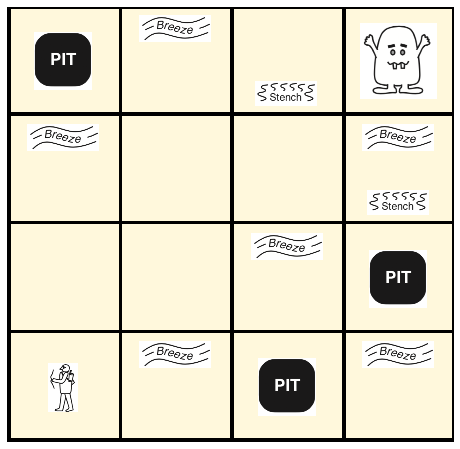

In [87]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
while W.juego_activo:# and (turno < 20):
    clear_output(wait=True)
    percept = percibir(W)
    #print("Percepción en turno", turno, ":", percept)
    accion = hybrid_wumpus_agent(percept, turno, W.heroe, W.direccion)
    #print(accion)
    W.transicion(accion)
    W.pintar_casilla()
    turno += 1
    plt.show()
    time.sleep(.5)

**Ejercicio 6:**

Modifique el código para que el héroe realice la toma de decisiones de acuerdo al siguiente pseudocódigo:

<img src="./imagenes/hybrid-wumpus-agent.png" width="400">

---

### En este notebook usted aprendió

1. Encontrar las casillas seguras para transitar.
* Fluentes y el aspecto dinámico del mundo.
* Diseñar un plan para ir de la casilla actual a una casilla objetivo.
* Toma de decisiones y planeación para superar el mundo del Wumpus.